In [14]:
## Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras

## Loading dataset

In [15]:
# Loading Fashion MNIST
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [16]:
print("shape of dataset for training : ", X_train.shape) ## (number of samples, horizontal dimension, vertical dimension)
print("shape of dataset for test : ", X_test.shape)

shape of dataset for training :  (60000, 28, 28)
shape of dataset for test :  (10000, 28, 28)


## visualize image of dataset

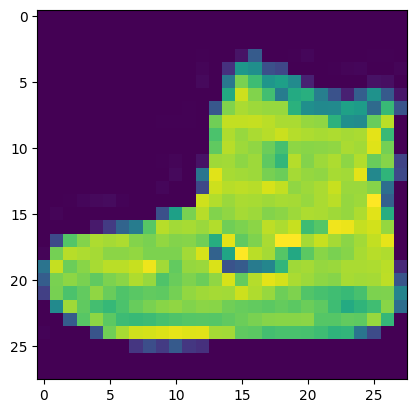

In [17]:
plt.imshow(X_train[0])

## Modelling

In [18]:
## Normalization(0 ~ 1)
X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train[:-5000], X_train[-5000:]
y_train, y_valid = y_train[:-5000], y_train[-5000:]

In [19]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [20]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

In [21]:
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3372 - rounded_accuracy: 0.8880 - val_loss: 0.3114 - val_rounded_accuracy: 0.9114
Epoch 2/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3043 - rounded_accuracy: 0.9165 - val_loss: 0.3022 - val_rounded_accuracy: 0.9174
Epoch 3/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2971 - rounded_accuracy: 0.9231 - val_loss: 0.2965 - val_rounded_accuracy: 0.9258
Epoch 4/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2931 - rounded_accuracy: 0.9267 - val_loss: 0.2927 - val_rounded_accuracy: 0.9288
Epoch 5/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2906 - rounded_accuracy: 0.9289 - val_loss: 0.2905 - val_rounded_accuracy: 0.9297
Epoch 6/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2885 - rounded_accuracy: 0.9308 - val_loss: 0.2922 - val_rounded_accuracy: 0.9315
Epoch 7/20
1719/1719 [==================

1/1 [==============================] - 0s 32ms/step


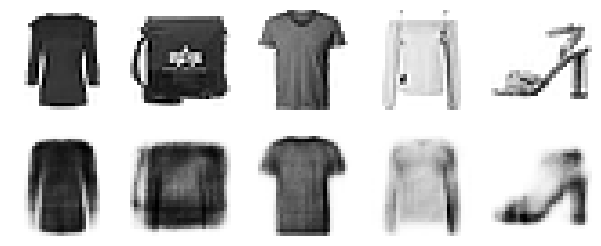

In [23]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off") 
    
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

show_reconstructions(stacked_ae)

## Visualize Fashion MNist

In [24]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

157/157 [==============================] - 0s 2ms/step


C:\Users\vaiv\Documents\blog\stacked_autoencoder\.stacked_ae\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\vaiv\Documents\blog\stacked_autoencoder\.stacked_ae\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


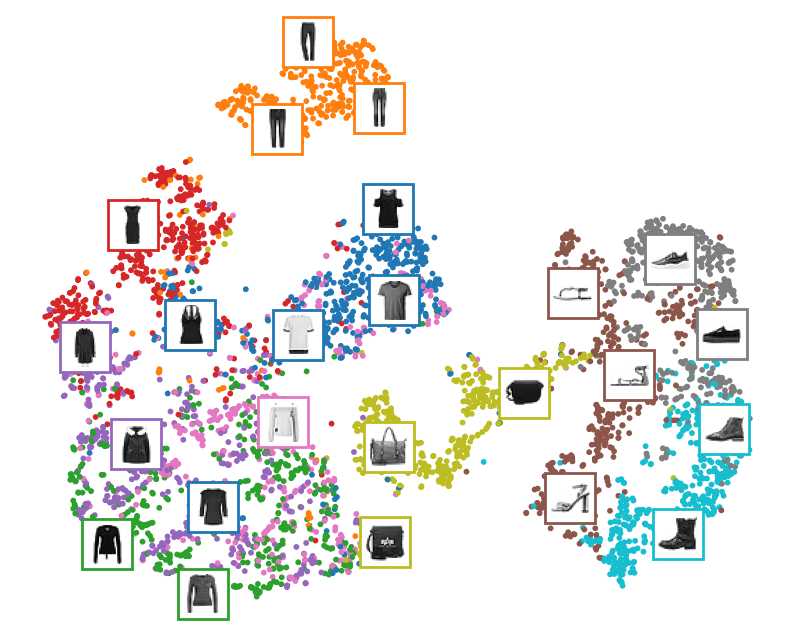

In [28]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
import matplotlib as mpl 

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## Tying weights

In [29]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [30]:
keras.backend.clear_session()

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3286 - rounded_accuracy: 0.8943 - val_loss: 0.3076 - val_rounded_accuracy: 0.9092
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2979 - rounded_accuracy: 0.9218 - val_loss: 0.2986 - val_rounded_accuracy: 0.9261
Epoch 3/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2920 - rounded_accuracy: 0.9274 - val_loss: 0.2927 - val_rounded_accuracy: 0.9243
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2889 - rounded_accuracy: 0.9301 - val_loss: 0.2885 - val_rounded_accuracy: 0.9326
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2868 - rounded_accuracy: 0.9321 - val_loss: 0.2874 - val_rounded_accuracy: 0.9314
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2853 - rounded_accuracy: 0.9335 - val_loss: 0.2857 - val_rounded_accuracy: 0.9347
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 82ms/step


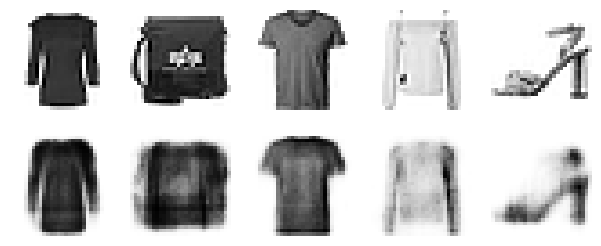

In [31]:
show_reconstructions(tied_ae)
plt.show()